## NLP and The Art of Wine Tasting

#### In this notebook we will be exploring the Wine Reviews dataset consisting of ~130K wines from all over the globe that have been reviewed by some of the famous wine tasters. The dataset consists of some structured fields including the wine title,variety, winery, (region, province & country of produce), price, and points scored on Wine Enthusiast.  I have done some basic descriptive and EDA plots just to get a high level feel for dataset.  What really motivated me to go after this dataset is the wine reviews that appear as unstructured text. Now i can mostly figuretell the type of wine based on the taste, however I have never been able to really verbalize my feelings about the feeling of drinking a particular type of wine.  The reviews in this dataset are very detailed talking about different aromas, palate, nose, acidity, food pairings etc and this is what attracted me the most.

#### The dataset was obtained from Kaggle (https://www.kaggle.com/zynicide/wine-reviews/data). The uploader of dataset claims to have directly scraped it from Wine Enthusiast.

#### Ok, so without further delay lets get going

In [1]:
import pandas as pd
from bokeh.palettes import viridis

import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np
import re
import nltk.tag as tag

from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim
import pickle 
import os
import codecs
import spacy
from spacy.lang.en import STOP_WORDS
import pandas as pd
import itertools as it
from sklearn.manifold import TSNE

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import nltk
from nltk.tokenize import WordPunctTokenizer
import os
import string
translator = str.maketrans('', '', string.punctuation)
import nltk.tag as tag
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import word2vec

In [3]:
%matplotlib inline 

In [8]:
# Download and unpack the file from https://www.kaggle.com/zynicide/wine-reviews/data
df = pd.read_csv('/data2/text_datasets/winedata.csv', index_col=0)

In [9]:
df['year'] = df['title'].str.extract('(\d+)')

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


### Check for missingness

In [10]:
df.isnull().any()

country                   True
description              False
designation               True
points                   False
price                     True
province                  True
region_1                  True
region_2                  True
taster_name               True
taster_twitter_handle     True
title                    False
variety                   True
winery                   False
year                      True
dtype: bool

In [6]:
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013


In [7]:
# Let's see the top 15 Countries and varieties
#print(df.country.value_counts()[:15])
#print('\n')
#print(df.variety.value_counts()[:15])
#print('\n')
#print(df.taster_name.value_counts()[:15])
#print('\n')
print(df.year.value_counts()[:15])

2013    15733
2012    15622
2014    15439
2011    12468
2010    12084
2015     9994
2009     9799
2008     7388
2007     7014
2006     5746
2016     3669
2005     3600
2004     1768
2000      756
2001      690
Name: year, dtype: int64


### Exploratory Data Analysis

*The following set of plots will have a bar plot and box plot grouped by different categories. The bar plots have counts in descending order where as no ordering has been used in Box plots. As a result, the colors between the two plots do not correspond to the same value.*
 
*Also, when plotting the box plots, in some cases I am showing a smaller subset when the counts for some category values are very low.*

 
#### Top countries whose wines got reviewed

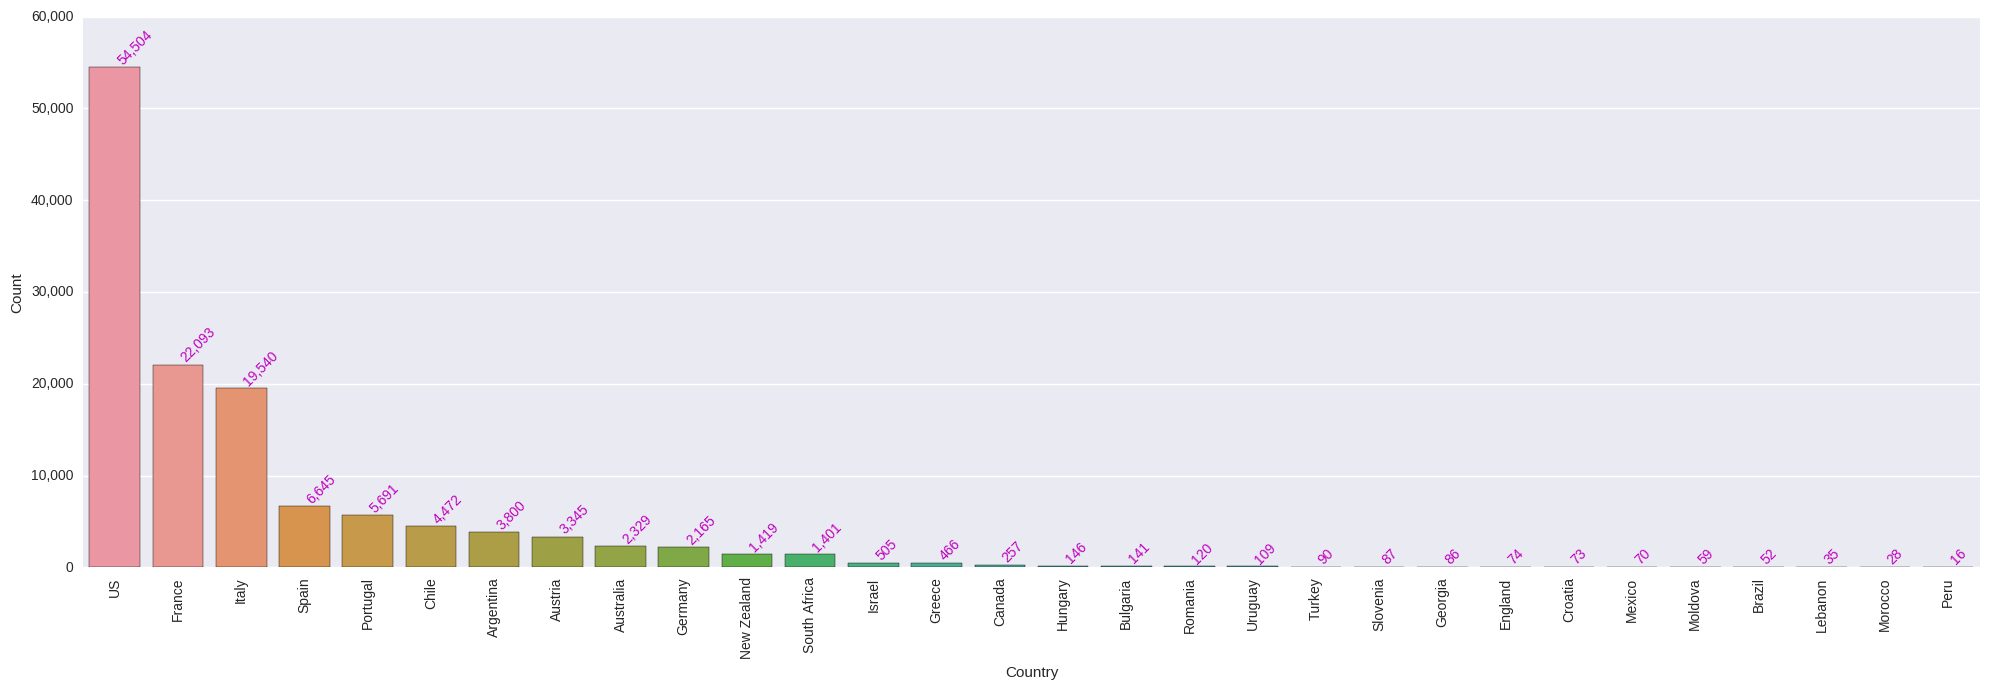

In [98]:
tmp = pd.DataFrame(df.country.value_counts()[:30])
tmp.columns = ['Count']
plt.figure(figsize=(20,7))
# plot barh chart with index as x values
ax = sns.barplot(tmp.index, tmp.Count)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Country", ylabel='Count')
# add proper Dim values as x labels

for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(tmp["Count"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

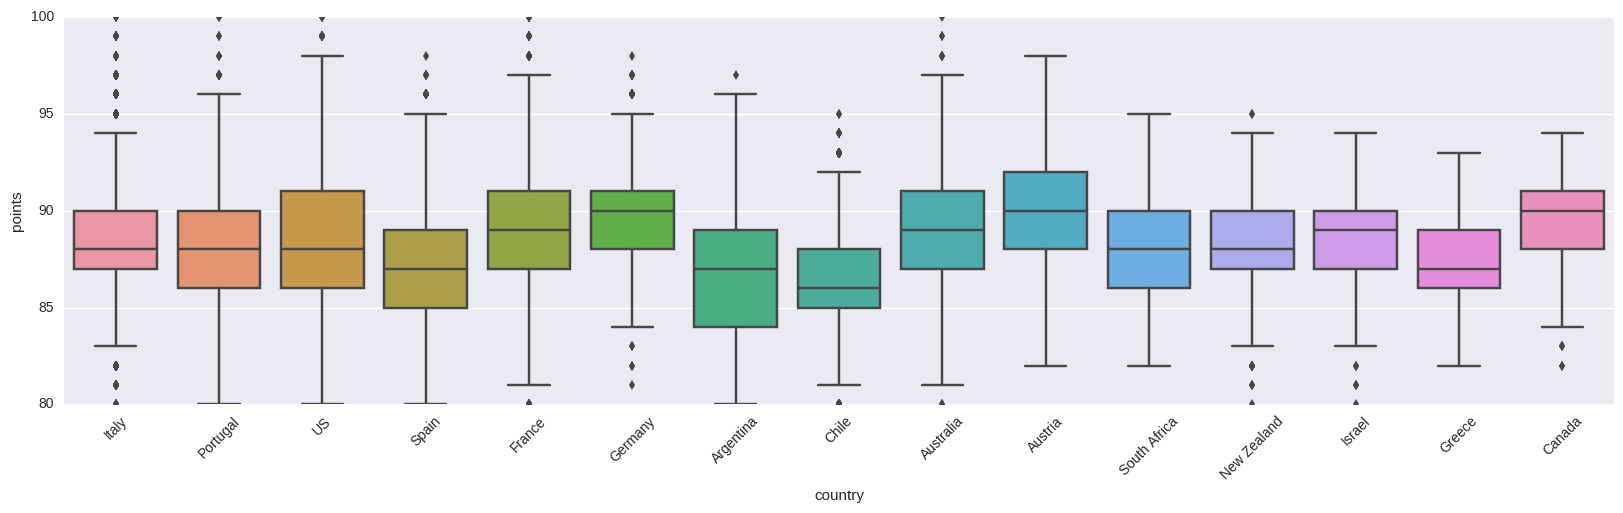

In [19]:
plt.subplots(figsize=(20,5))
ax = sns.boxplot(x="country", y="points", data=df.loc[(df['country'].isin(list(df.country.value_counts()[:15].index)))])
plt.xticks(rotation=45)

#### German & Austrian wines seem to be at the top. Austrian wines have a more balanced distribution with a median at 90 where as the French have a slight left skew and the distribution is a bit tighter.

#### South American and Spanish wines fall at the bottom of the pack. Either the Vino no good or the raters too hard ! Lets figure out  next block where we see the heat map of tasters ~ country.

#### Most reviewed wineries and boxplots on the point received

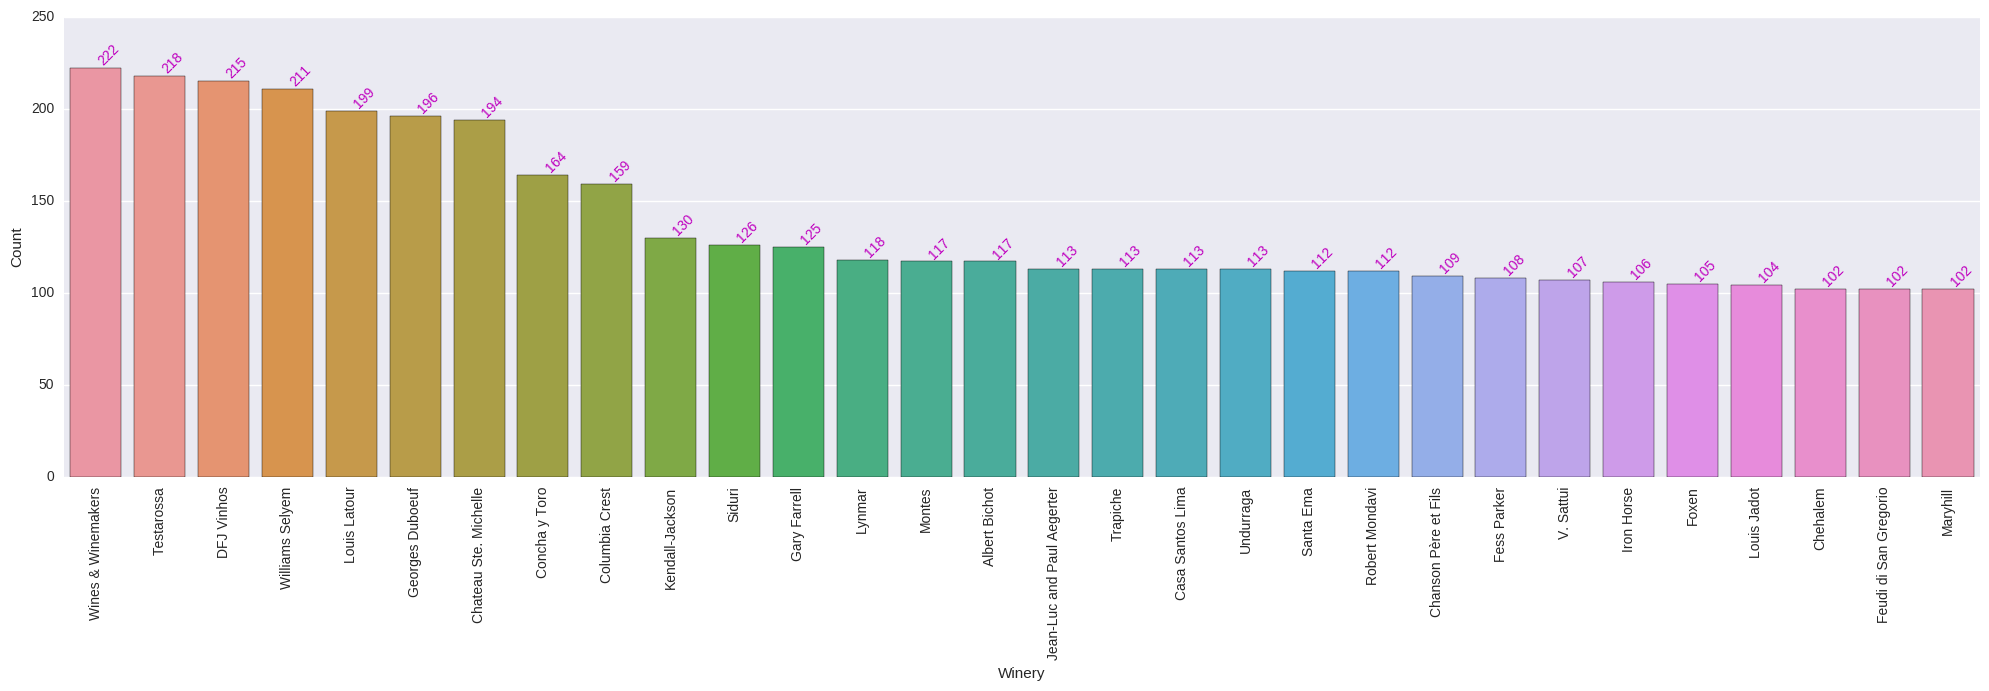

In [99]:
tmp = pd.DataFrame(df.winery.value_counts()[:30])
tmp.columns = ['Count']
plt.figure(figsize=(20,7))
# plot barh chart with index as x values
ax = sns.barplot(tmp.index, tmp.Count)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Winery", ylabel='Count')
# add proper Dim values as x labels

for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(tmp["Count"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

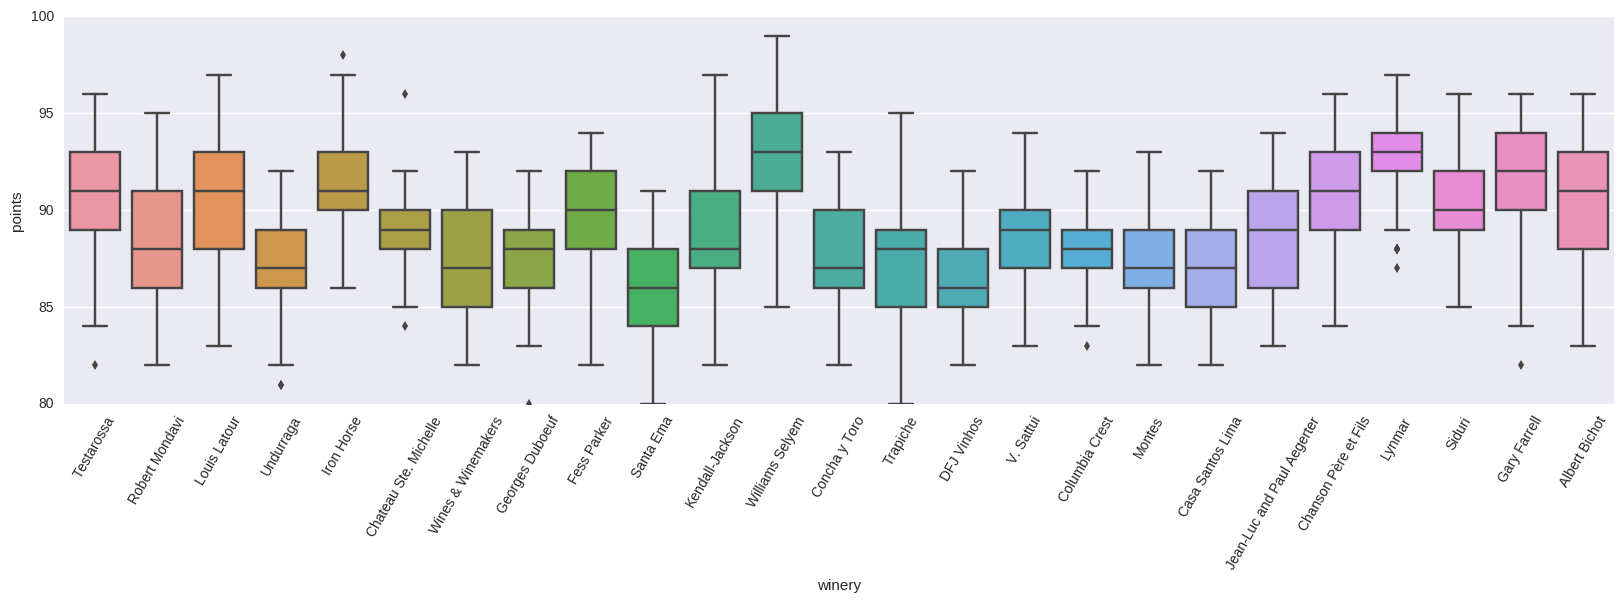

In [13]:
plt.subplots(figsize=(20,5))
ax = sns.boxplot(x="winery", y="points", data=df.loc[(df['winery'].isin(list(df.winery.value_counts()[:25].index)))])
plt.xticks(rotation=60)

#### Most represented Wine Tasters and boxplots on the point scored by them

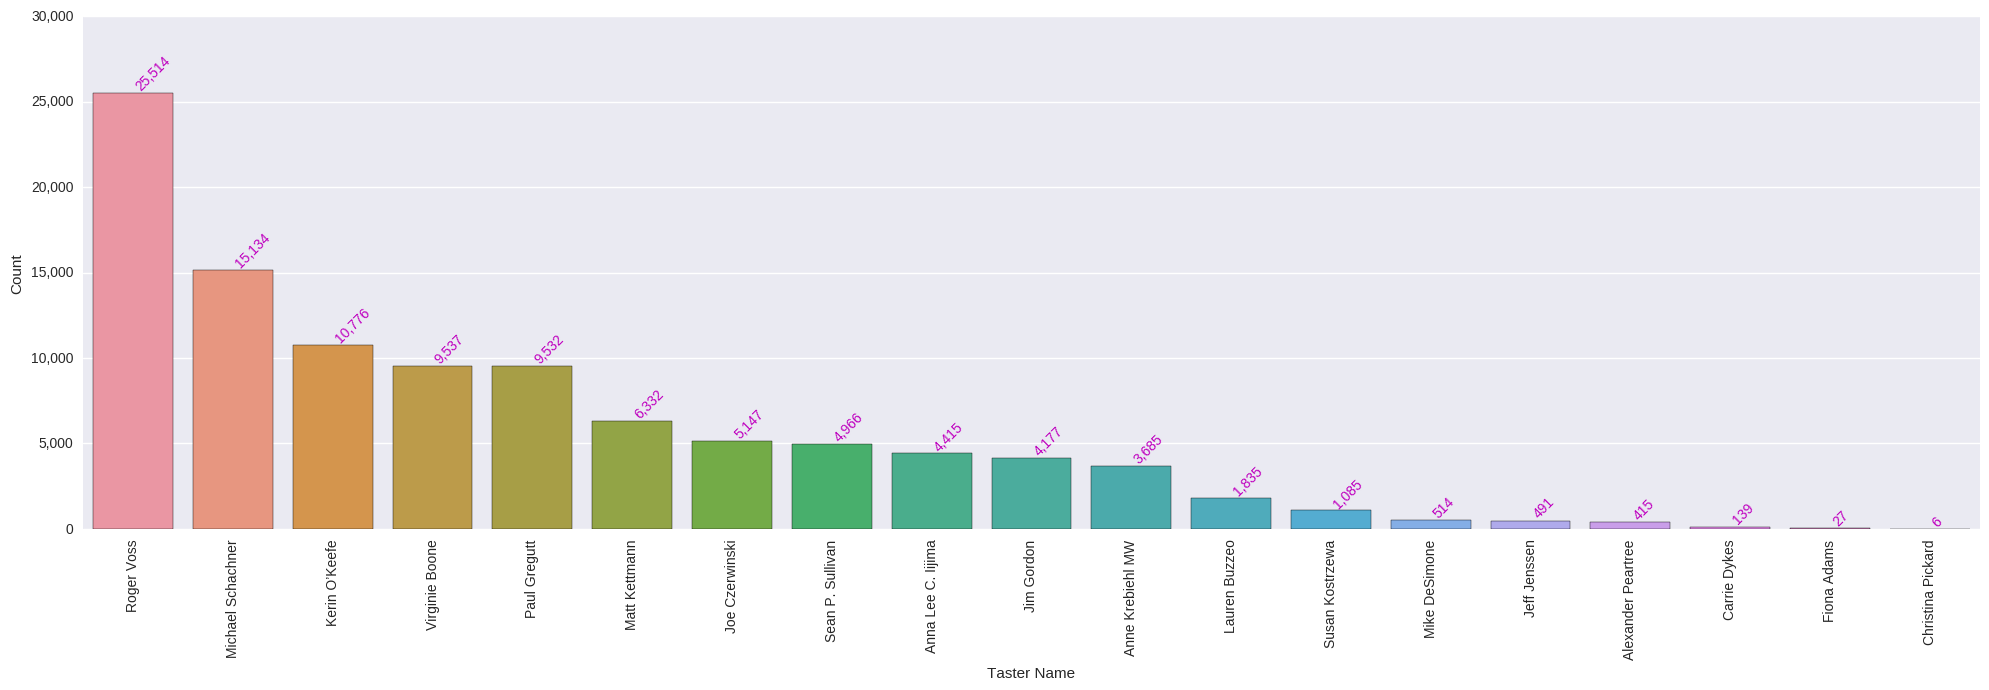

In [14]:
tmp = pd.DataFrame(df.taster_name.value_counts()[:30])
tmp.columns = ['Count']
plt.figure(figsize=(20,7))
# plot barh chart with index as x values
ax = sns.barplot(tmp.index, tmp.Count)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Taster Name", ylabel='Count')
# add proper Dim values as x labels

for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(tmp["Count"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
plt.tight_layout()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

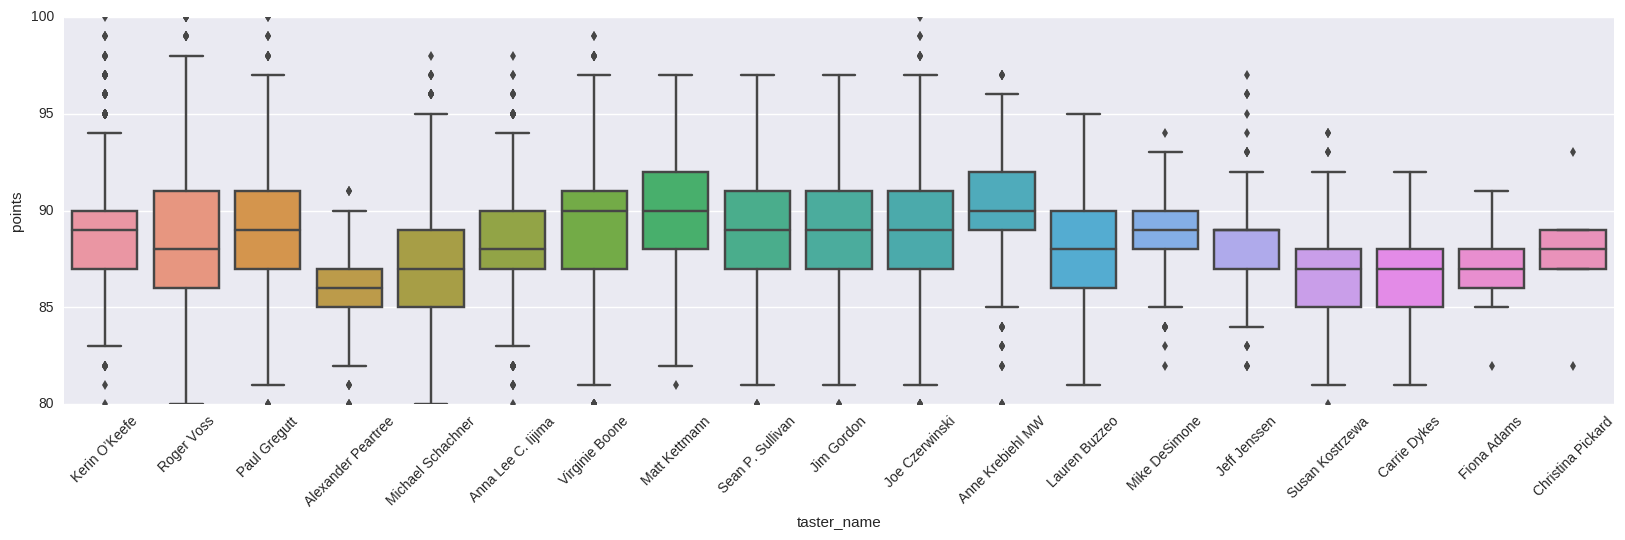

In [16]:
plt.subplots(figsize=(20,5))
ax = sns.boxplot(x="taster_name", y="points", data=df.loc[(df['taster_name'].isin(list(df.taster_name.value_counts()[:30].index)))])
plt.xticks(rotation=45)

#### Bivariate Analysis : Country ~ Wine Variety
  
  
#### The next two plots show the representation of different wine varieties by country. We look at the count as well as the median points scored by the wine. 


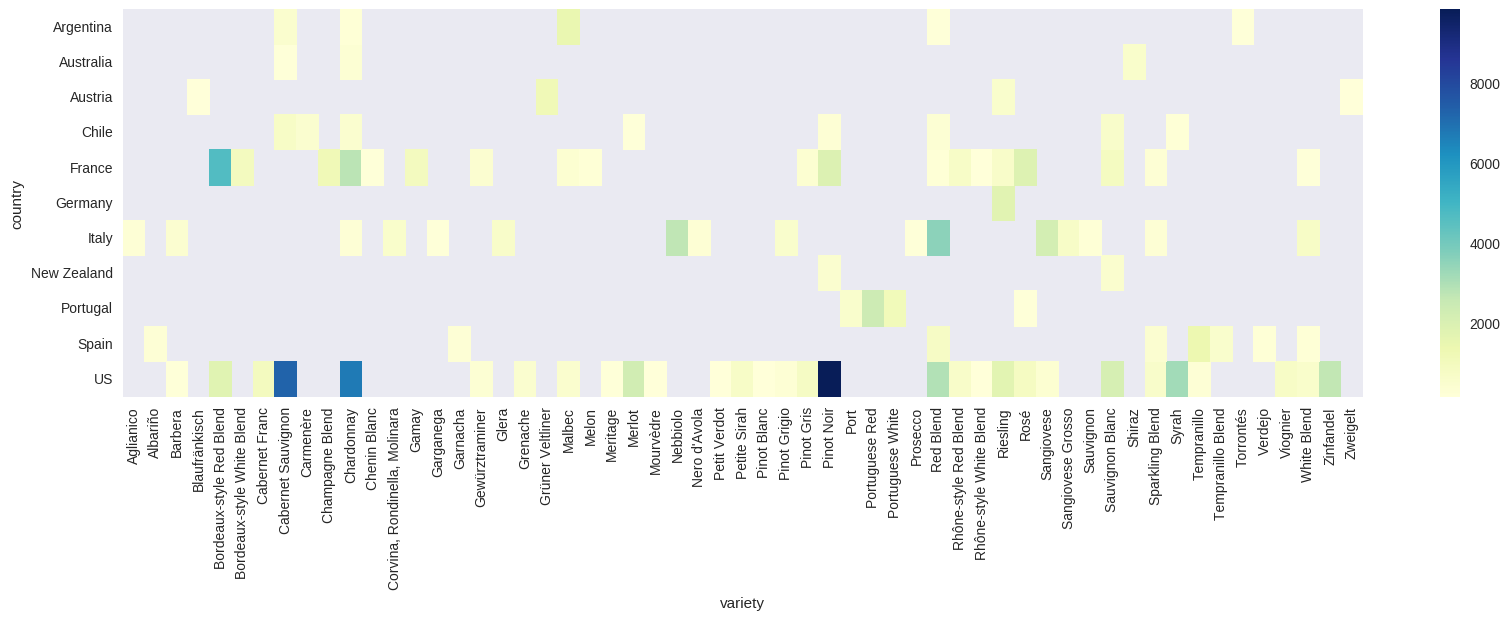

In [73]:
tmp = df.groupby(['country','variety']).size().reset_index()
tmp.columns = ['country','variety','count']
tmp = tmp.sort_values(by=['count'], ascending=False)[:100]
tmp = tmp.dropna()
result = tmp.pivot(index='country', columns='variety', values='count')
plt.subplots(figsize=(20,5))
sns.heatmap(result, cmap="YlGnBu")

#### A lot of Pinot Noir followed by Cabernet Sauvignon from US in the dataset. Happens to be my favorite grapes as well !
#### US, France, & Italy are the Top 3 in terms of number of unique wine variety's represented in this dataset.


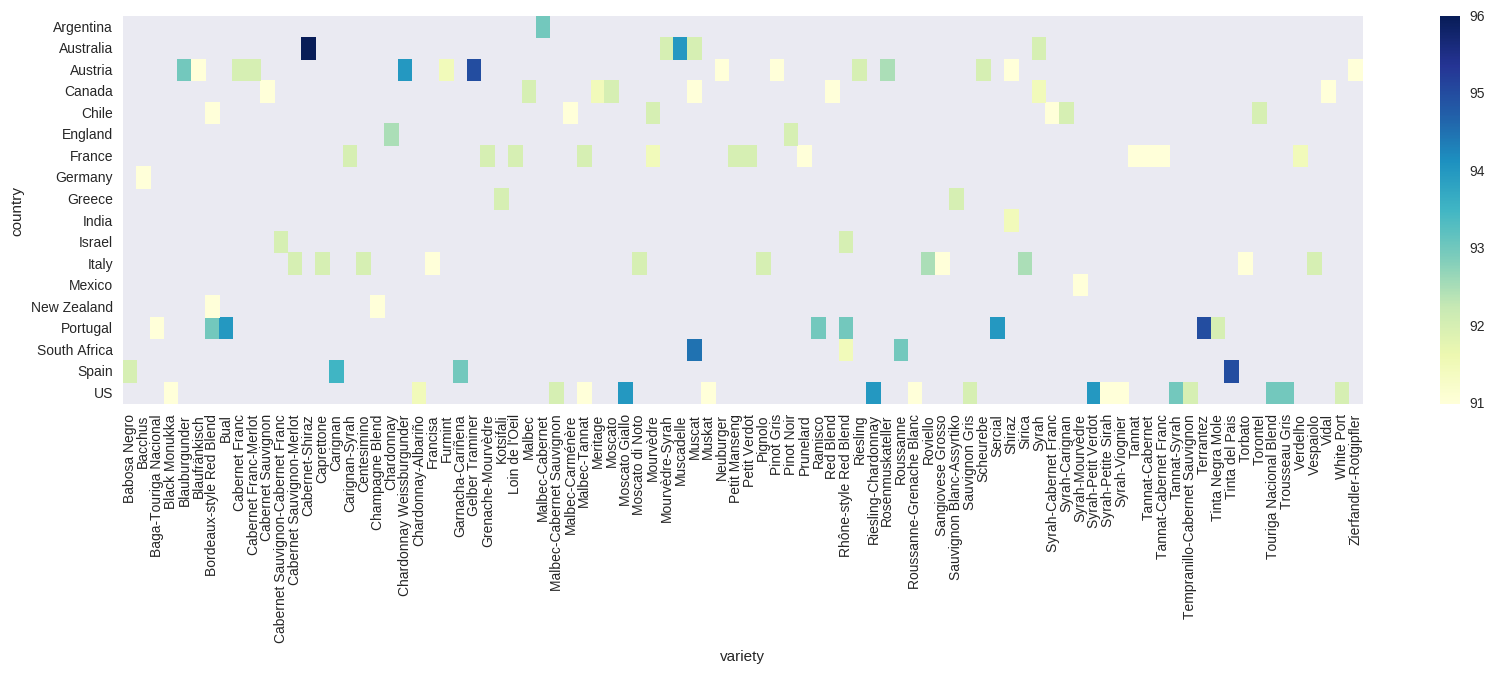

In [71]:
tmp = df.groupby(['country','variety'])[['points']].median().reset_index()
tmp.columns = ['country','variety','points']
tmp = tmp.sort_values(by=['points'], ascending=False)[:100]

tmp = tmp.dropna()
result = tmp.pivot(index='country', columns='variety', values='points')
plt.subplots(figsize=(20,5))
sns.heatmap(result, cmap="YlGnBu")

#### Next we look taster and country on similat heat plots

/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


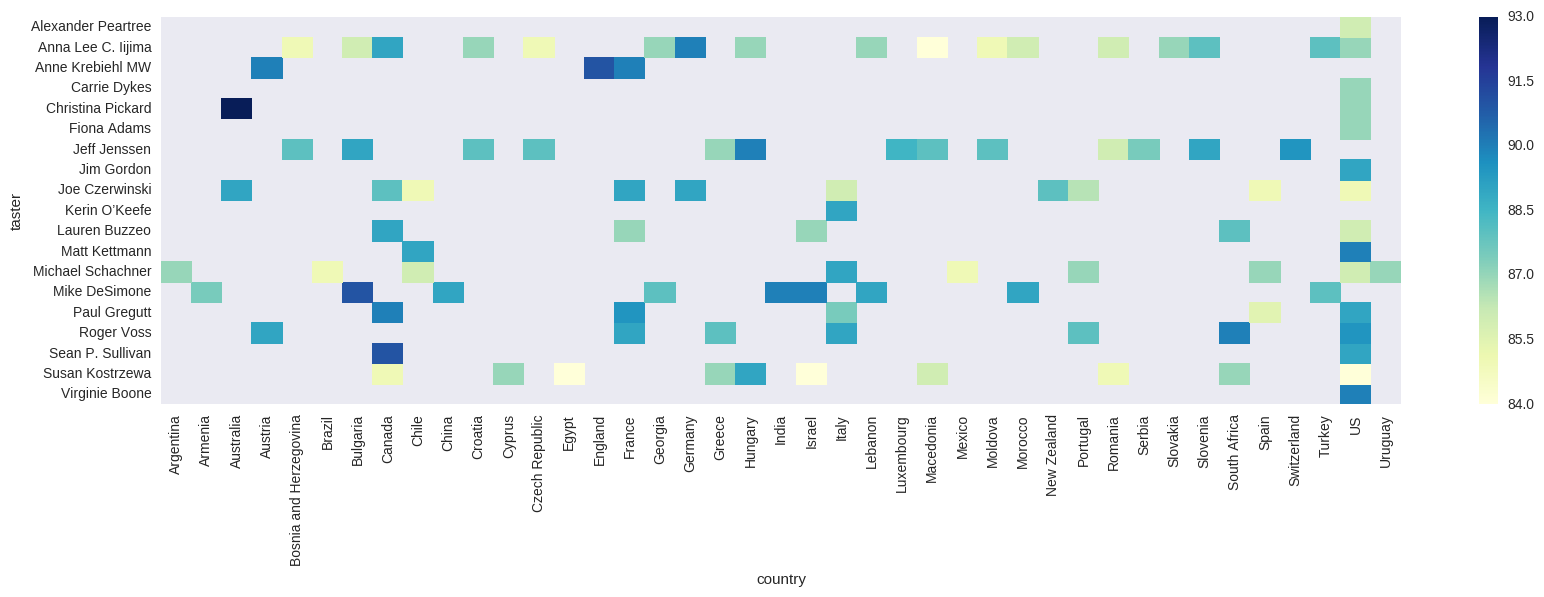

In [21]:
tmp = df.groupby(['taster_name','country'])[['points']].median().reset_index()
tmp.columns = ['taster','country','points']
tmp = tmp.sort_values(by=['points'], ascending=False)[:100]

tmp = tmp.dropna()
result = tmp.pivot(index='taster', columns='country', values='points')
plt.subplots(figsize=(20,5))
sns.heatmap(result, cmap="YlGnBu")

#### As seen from above, Argentinian wines have only been reviewed by a single taster ( Michael Schachner ), Chilean & Spanish wines have been reviewed by 3 tasters. Austrian and German wines have been reviewed by 2 tasters.

#### Next we look at the cross-section of taster and wine variety

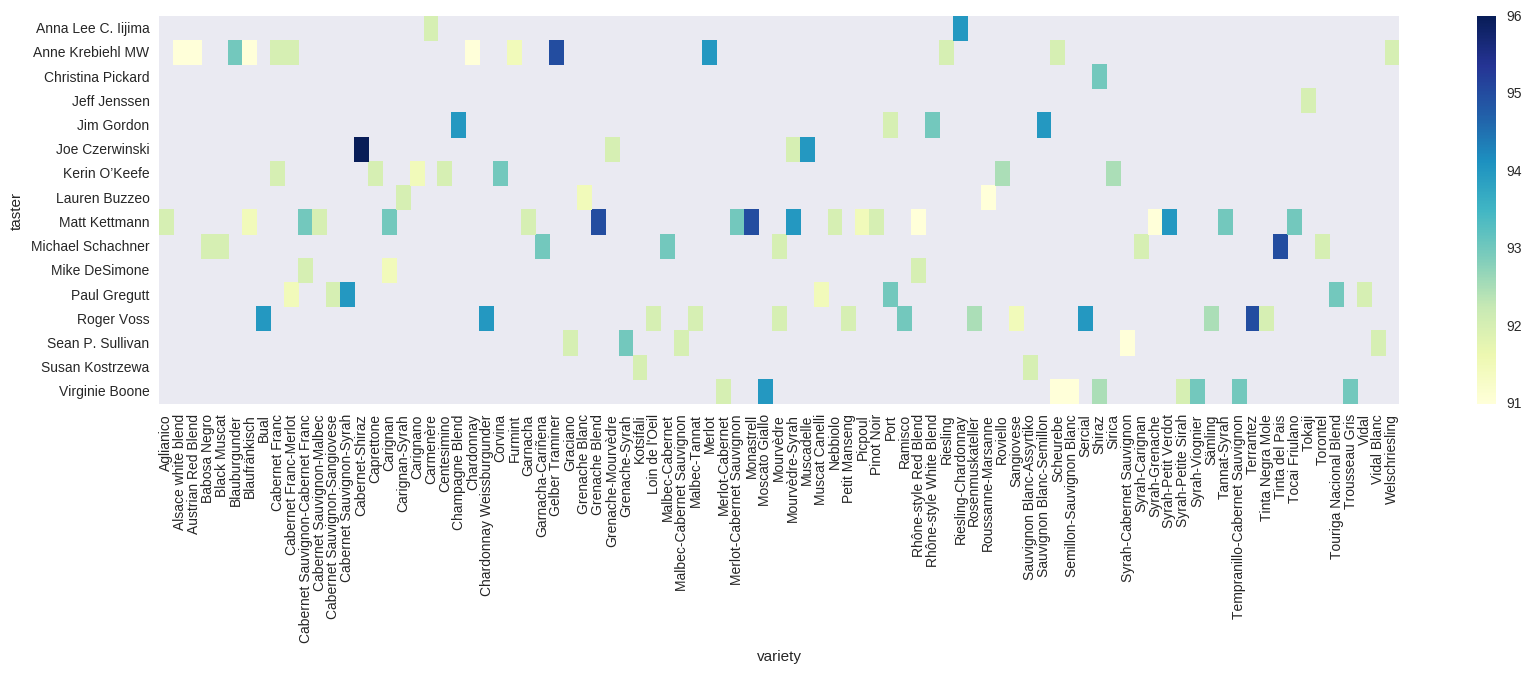

In [88]:
tmp = df.groupby(['taster_name','variety'])[['points']].median().reset_index()
tmp.columns = ['taster','variety','points']
tmp = tmp.sort_values(by=['points'], ascending=False)[:100]

tmp = tmp.dropna()
result = tmp.pivot(index='taster', columns='variety', values='points')
plt.subplots(figsize=(20,5))
sns.heatmap(result, cmap="YlGnBu")

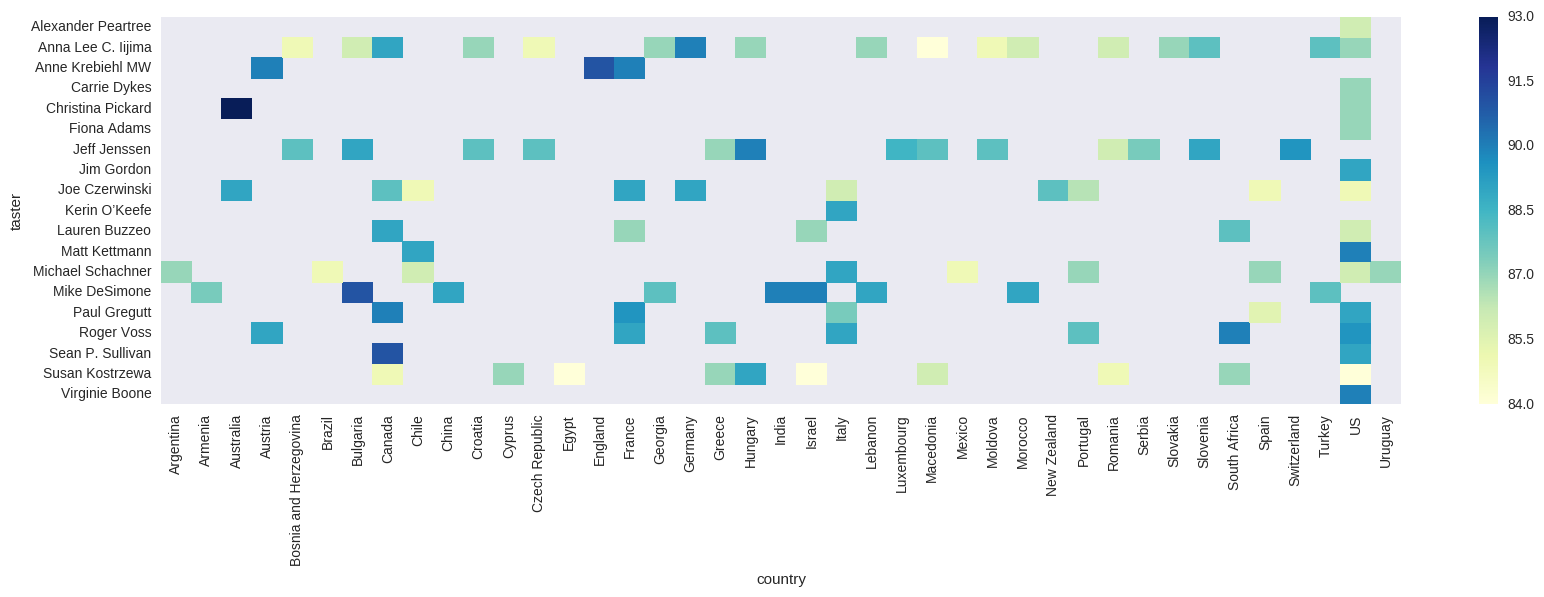

In [11]:
tmp = df.groupby(['taster_name','country'])[['points']].median().reset_index()
tmp.columns = ['taster','country','points']
tmp = tmp.sort_values(by=['points'], ascending=False)[:100]

tmp = tmp.dropna()
result = tmp.pivot(index='taster', columns='country', values='points')
plt.subplots(figsize=(20,5))
sns.heatmap(result, cmap="YlGnBu")

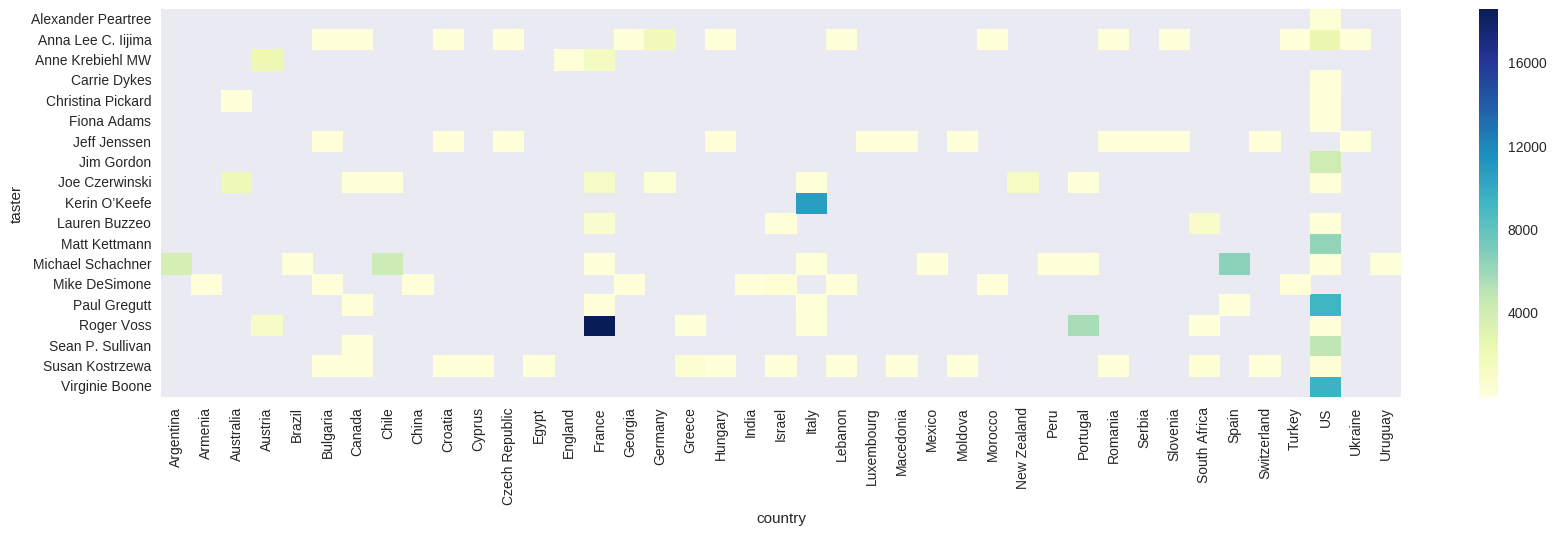

In [93]:
tmp = df.groupby(['taster_name','country']).size().reset_index()
tmp.columns = ['taster','country','count']
tmp = tmp.sort_values(by=['count'], ascending=False)[:100]

tmp = tmp.dropna()
result = tmp.pivot(index='taster', columns='country', values='count')
plt.subplots(figsize=(20,5))
sns.heatmap(result, cmap="YlGnBu")

#### Roger Voss tastes quiet a lot of French wine
#### Michael Schachner is into South American and Spanish wines
#### Kerin OKeefe is rocking the Italian vino

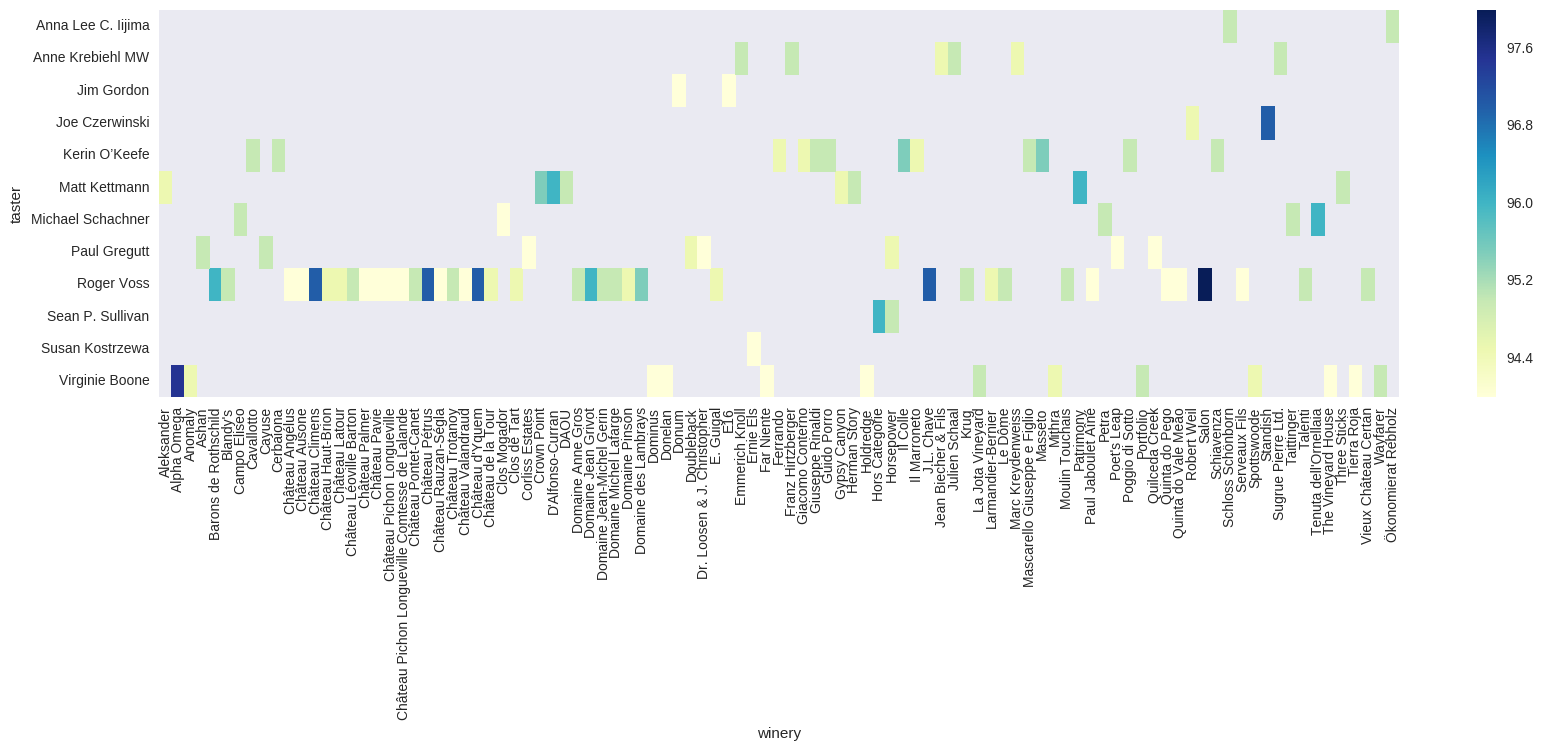

In [10]:
tmp = df.groupby(['taster_name','winery'])[['points']].median().reset_index()
tmp.columns = ['taster','winery','points']
tmp = tmp.sort_values(by=['points'], ascending=False)[:100]

tmp = tmp.dropna()
result = tmp.pivot(index='taster', columns='winery', values='points')
plt.subplots(figsize=(20,5))
sns.heatmap(result, cmap="YlGnBu")

#### Let's do a quick plot to see the relation between price of the bottle and the points awarded. The continuous line curve fit is from a 3rd order polynomial. (1st and 2nd order were underfitting) Seems to be following very closely until the last point  (score = 100 points) where it misses the mark. Ohh well...We'll leave them to some other time.

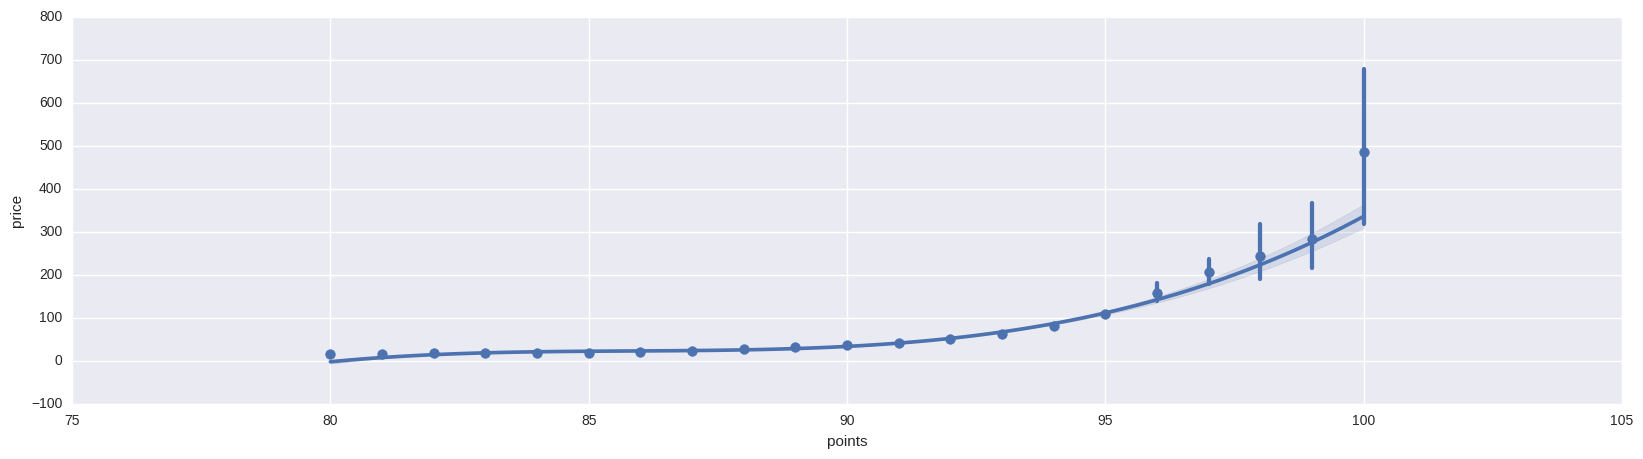

In [30]:
plt.subplots(figsize=(20,5))
sns.regplot(x="points", y="price", data=df,order=3, truncate = True,x_estimator=np.mean)

### Fun with Text !
 
#### Switching gears and moving away from basic descriptive plots. Next we will build a word2vec model using the Wine Reviews corpus. I will be using that model to show few different things including the fun with Word Vector algebra which some of you might already be familiar with.  However, before all that fun stuff, we need to do some pre-processing that includes tokenization, stop-word removal, punctuation removal and lemmatinaztion. Basic pre-processing tasks...

In [36]:
stopArr =  [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
stoplist = ' '.join(map(str, stopArr))

#### Function to lowercase, tokenize, remove stopwords, and lemmatize the reviews.  In this function block, I am leveraging sent_tokenize and word_tokenize from NLTK. Later in this notebook, we will do somilar tasks using spaCY

In [34]:
def token_lemmatize(text):
    text = text.translate(translator)
    #print(text)
    review = sent_tokenize(text.lower())
    out = []
    for sent in review:
        new_sent = []
        for word in tag.pos_tag(word_tokenize(sent)):
            if word[0] not in stoplist:
                new_sent.append(lemmatizer.lemmatize(word[1], word[0].lower()))
        if len(new_sent) > 0:
            out.append(new_sent)
    return out

In [35]:
df['description_token'] = df['description'].apply(token_lemmatize)
df.to_pickle('/data2/text_datasets/winedata.p')

In [25]:
#Read from previously saved dataframe
#df = pd.read_pickle('/data2/text_datasets/winedata.p')

In [5]:
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,description_token
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,"[[aroma, include, tropical, fruit, broom, brim..."
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,"[[ripe, fruity, wine, smooth, still, structure..."
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,"[[tart, snappy, flavor, lime, flesh, rind, dom..."


#### Now that the description column has gone through the pre-processing steps and saved as a new column called description_token, let us pack that entire column we just created into list object. I could have short circuited the creation of new column and directly created a list, but doing it for the purpose of demo.

In [14]:
sents = []
for sent in df['description_token']:
    sents += sent
    
# saving for later use
with open('/data2/text_datasets/winedescriptiontokens.p', 'wb') as f:
    pickle.dump(sents, f)

#### Here we build the Word2Vec model using gensim. Its an awesome Text modeling library that you should check out if you work in this space. Here is a quick demo for getting started with Word2Vec using gensim. https://rare-technologies.com/word2vec-tutorial/

#### I am also creating a couple of helper functions that I will be using regularly in the word algebra demo section that follows next.

In [15]:
model = word2vec.Word2Vec(sents, size=300, window=5, min_count=5)
model.save('/data2/text_models/word2vec/gensim/winedemo/model')

In [6]:
#Load previously saved model
#model = word2vec.Word2Vec.load('/data2/text_models/word2vec/gensim/winedemo/model')  # you can continue training with the loaded model!

In [39]:
def get_related_terms(token, topn=10):
    """
    look up the topN most similar terms to token
    and print them as a formatted list
    """

    for word, similarity in model.wv.most_similar(positive=[token], topn=topn):

        print(u'{:20} {}'.format(word, round(similarity, 3)))

In [40]:
def word_algebra(add=[], subtract=[], topn=1):
    """
    combine the vectors associated with the words provided
    in add= and subtract=, look up the topn most similar
    terms to the combined vector, and print the result(s)
    """
    answers = model.wv.most_similar(positive=add, negative=subtract, topn=topn)
    
    for term, similarity in answers:
        print(term)

#### Length of model vocabulary

In [11]:
len(model.wv.vocab)

13051

#### Word Similarity. Here I will show 10 closest words to the word of my choice in the vector space.  I will go through names of fruits, nose/smell of wine, geographic places/locations. 

#### Fruits

In [90]:
get_related_terms(u'cherry')

blackcherry          0.649
licorice             0.642
blueberry            0.603
boysenberry          0.578
mocha                0.565
cranberry            0.555
clove                0.549
currant              0.548
mulberry             0.531
pomegranate          0.527


In [66]:
get_related_terms(u'apple')

greenapple           0.665
nectarine            0.638
cantaloupe           0.598
honeydew             0.596
quince               0.596
banana               0.593
redapple             0.593
apricot              0.592
papaya               0.577
melon                0.574


#### Nose

In [68]:
get_related_terms(u'peat')

nori                 0.792
ash                  0.776
moss                 0.774
tapenade             0.73
frond                0.72
ember                0.703
caper                0.698
damp                 0.698
seaweed              0.685
dust                 0.677


In [70]:
get_related_terms(u'earthy')

earth                0.715
woodsy               0.702
leathery             0.656
meaty                0.64
gamy                 0.606
leafy                0.59
brambly              0.585
mossy                0.573
compost              0.559
feral                0.558


#### Places

In [64]:
get_related_terms(u'napa')

alexander            0.834
oakville             0.816
livermore            0.723
sonoma               0.723
cult                 0.717
rutherford           0.709
anderson             0.706
yarra                0.676
columbia             0.671
edna                 0.669


In [65]:
get_related_terms(u'burgundy')

portugal             0.875
aube                 0.833
chalonnaise          0.829
chablis              0.828
village              0.826
meursault            0.825
france               0.824
lisbon               0.808
cooperative          0.804
lisboa               0.804


### W2Vec algebra fun

#### food pairings with wine

In [75]:
word_algebra(add=[u'seafood', u'cabernet'], subtract=[u'merlot'])

shellfish


#### time of day & food

    * if you add steak to night and subtract day from it, it becomes lamb
    * if you add fish to night and subtract day from it, it becomes chicken

In [85]:
word_algebra(add=[u'steak', u'night'], subtract=[u'day'])

lamb


In [46]:
word_algebra(add=[u'fish', u'night'], subtract=[u'day'])

chicken


#### wine and flavors

    * If you take acidity out from a oak barrel merlot, it tastes like a verdot :)

In [48]:
word_algebra(add=[u'oak', u'merlot'], subtract=[u'acidic'])

verdot


#### Voila !!!! Pretty daarn close and we did not have to feed any hard rules to tell which words are similar to each other. Thats the beauty of Word2Vec.  The language taught the model to understand word similarity.

#### A more formal definition from the paper "Efficient Estimation of Word Representations in Vector Space" (https://arxiv.org/abs/1301.3781) by the authors Mikolov; et al. 

*"Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.*


#### Lastly, any demo would be incomplete without interacting with the word vector space in 2D using tSNE

### Visialize the word embeddings in vector space using tSNE

#### Perform the following steps:
 
    * Build a list of the terms, integer indices,and term counts from the model vocabulary
    * Sort by the term counts, so the most common terms appear first
    * Unzip the terms, integer indices, and counts into separate lists
    * Create a DataFrame with the vectors as data,and the terms as row labels
    * Take a subset of this to include only the Top 5000 terms. This is called as tsne_input
    * Initiate TSNE object
    * Perform the fit_transform function using the values of dataframe tsne_input. This will return tnse_vectors that is converted to dataframe
    * Create a new column called word in tsne_vectors that has the index values
    * save dataframe tsne_vectors for later use

In [8]:
ordered_vocab = [(term, voc.index, voc.count) for term, voc in model.wv.vocab.items()]
ordered_vocab = sorted(ordered_vocab, key=lambda k: -k[2])
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)
word_vectors = pd.DataFrame(model.wv.syn0[term_indices, :], index=ordered_terms)

tsne_input = word_vectors
tsne_input = tsne_input.head(5000)
tsne = TSNE()
tsne_vectors = tsne.fit_transform(tsne_input.values)

    

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(tsne_input.index),
                            columns=[u'x_coord', u'y_coord'])

tsne_vectors[u'word'] = tsne_vectors.index
tsne_vectors.to_pickle('/data2/text_datasets/winedata.p')

#### Read previously created TSNE dataframe

In [4]:
#tsne_vectors = pd.read_pickle('/data2/text_datasets/tsne_vectors.p')

In [7]:
tsne_vectors.head()

,x_coord,y_coord,word
wine,-5.811999,-1.312554,wine
flavor,-3.374783,-4.183389,flavor
fruit,-3.784425,-3.456304,fruit
aroma,4.859846,-1.785426,aroma
finish,-3.284261,-1.860267,finish


In [9]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

In [29]:
from bokeh.resources import INLINE

In [27]:
output_notebook()

Loading BokehJS ...

In [30]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

#### You will see how related words form clusters. For example the food pairing cluster in the south east portion of the plot, calendar years are at the bottom, north east direction has colors..etc.. You can also search the location  (x,y coords) of a word using a simple search as below

In [22]:
tsne_vectors[tsne_vectors.word.str.contains('verdot') | tsne_vectors.word.str.contains('merlot') | tsne_vectors.word.str.contains('pinot')]

,x_coord,y_coord,word
pinot,3.607289,6.007896,pinot
merlot,3.819027,4.285755,merlot
verdot,4.164897,3.960447,verdot
pinotage,-13.048625,1.500052,pinotage
merlotbased,-13.157325,2.023181,merlotbased
merlotdominated,-13.229220,2.687178,merlotdominated


### Sentence Distances

#### Now that we have calculated word distances/similarities, let us now dig deeper into the reviews and see if we can calculate the distance between the reviews. I will be using Word Movers Distance (http://proceedings.mlr.press/v37/kusnerb15.pdf) as the distance metric between the reviews.

We will compare reviews for :
 
   1. Same variety wine by Top 10 reviewers for that variety for the same year (2015) and the wine with the highest points for each taster. (I will be picking Pinot Noir which happens to be my favorite)
   2. Different variety of wine from the same reviewer
   3. Same variety, same reviewer, different regions
   4. Same variety, same winery, same reviewer, different years
    

#### 1.0 Same variety wine by Top 10 reviewers for that variety for the same year (2015) and the wine with the highest points when there are multiple reviews by the same taster. I will be picking Pinot Noir which happens to be my favorite

In [57]:
pinot_df = df.loc[(df['variety'] == 'Pinot Noir') & (df['year'] == '2015')]
pinot_df = pinot_df[['taster_name','description','points','title','description_token','province']]
pinot_df = pinot_df.loc[pinot_df['taster_name'].isin(pinot_df.taster_name.value_counts()[:10].index)]

In [58]:
pinot_df.taster_name.value_counts()[:10].index

Index(['Paul Gregutt', 'Matt Kettmann', 'Roger Voss', 'Virginie Boone',
       'Michael Schachner', 'Jim Gordon', 'Joe Czerwinski', 'Anne Krebiehl MW',
       'Lauren Buzzeo', 'Anna Lee C. Iijima'],
      dtype='object')

    * Points scored is currently a discrete variable. Adding little bit of random noise to the points scored so no 2 wines have the exact same score. This will help in rank ordering later on.

In [59]:
pinot_df['points_randn'] = np.random.normal(0, .1, pinot_df.shape[0])
pinot_df['points_randn'] = pinot_df['points'] + pinot_df['points_randn']
pinot_df["group_rank"] = pinot_df.groupby("taster_name")["points_randn"].rank(ascending=0,method='dense')
pinot_df_topranks = pinot_df.loc[(pinot_df['group_rank'] == 1)]
pinot_df_topranks = pinot_df_topranks.reset_index()

#### Normalizing the raw Word2Vec model vectors to unit norm.  

Normalizing (L2 norm) the word2vec vectors first to bring them on the same scale (sum of squares = 1). This is implemented in gensim and can be called using the following:

*model.init_sims(replace=True)*

**If replace is set, forget the original vectors and only keep the normalized ones = saves lots of memory!. Note that you cannot continue training or inference after doing a replace. The model becomes effectively read-only = you can call most_similar, similarity etc., but not train or infer_vector.**


In [61]:
model.init_sims(replace=True)
word_vectors = model.wv

#### shows that sum of squares adds to 1

In [86]:
print(sum(word_vectors['cherry']**2))
print(sum(word_vectors['verdot']**2))

0.9999999663087351
0.9999999136741735


/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


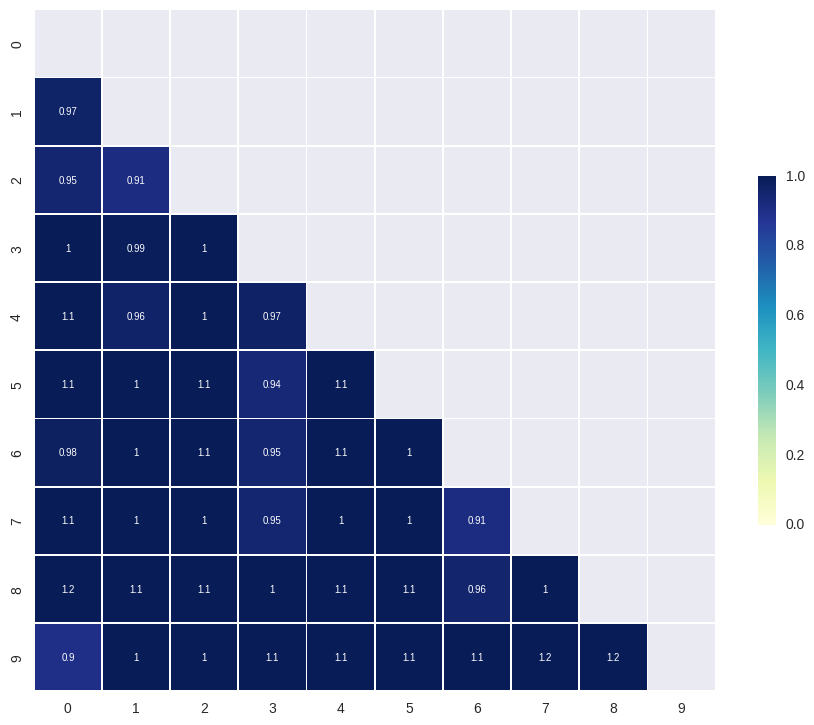

In [72]:
sim_score = []
for doc in pinot_df_topranks['description_token']:
    doc = doc[0]
    #print(doc)
    for other_doc in pinot_df_topranks['description_token']:
        other_doc = other_doc[0]
        sim_score.append(model.wv.wmdistance(doc, other_doc)) 

sim_mat = np.array(sim_score).reshape((10, 10))

mask = np.zeros_like(sim_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap="YlGnBu"

sns.heatmap(sim_mat, mask=mask, cmap=cmap, vmax=.3, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, annot_kws={"size": 7})
        

#### Everything except for a few pairs like 1-4, 1-8, 7-8 have a normalized distance close to 1. Lets us investigate those 3 pairs


In [207]:
print('1:\n')
print(pinot_df_topranks.description[1])
print('\n4:\n')
print(pinot_df_topranks.description[4])
print('\n8:\n')
print(pinot_df_topranks.description[8])
print('\n7:\n')
print(pinot_df_topranks.description[7])

1:

Winemaker: Andries Burger. There's a very fine balance in this attractive Pinot, offering both ripe red-cherry and forest-berry fruits that are graced with hits of bittersweet cocoa, cola spice and forest floor. It's silky and seductive, with well-integrated tannins and ample acidity to keep the palate fresh. Pleasant notes of earthy baking spice and cherry pit carry on through the close. An elegant and refined wine, this should age well through 2023.

4:

A shy nose hints at crushed autumn leaves, fresh red fruit and soft vanilla. The palate has that same interplay of earthiness and red-berry fruit, supported by a gentle nudge of oaky vanilla. Slender and layered, the body shows a firm grip of very fine tannin. Freshness is evident on the finish. While lovely now, this elegant, poised wine will blossom over the coming years: the fruit is pure and ample; the structure firm and lasting. Drink 2020–2030.

8:

From one of the most coveted vineyards in the Central Coast, this is a well

#### 3.0 Same variety, same reviewer, different regions

    * Checking reviewers that have the most diverse coverage in terms of provinces. Michael Schachner, Anna Lee C. Iijima seem to be good candidates

In [69]:
print(pinot_df.groupby(['province','taster_name']).size())

province               taster_name       
Aconcagua Costa        Michael Schachner       1
Aconcagua Valley       Michael Schachner       3
Alsace                 Anne Krebiehl MW       18
Burgenland             Anne Krebiehl MW        2
Burgundy               Roger Voss            152
Bío Bío Valley         Michael Schachner       3
Cachapoal Valley       Michael Schachner       1
California             Jim Gordon             49
                       Matt Kettmann         209
                       Virginie Boone        148
Canelones              Michael Schachner       1
Carnuntum              Anne Krebiehl MW        1
Casablanca Valley      Michael Schachner      12
Central Otago          Joe Czerwinski          6
Central Valley         Michael Schachner       4
Ceres Plateau          Lauren Buzzeo           1
Chile                  Michael Schachner       2
Coastal Region         Lauren Buzzeo           1
Colchagua Costa        Michael Schachner       1
Elgin                  Laur

#### Creating a subset dataframe for Michael Schachner and picking 1 top scoring wine from 10 different provinces

In [70]:
pinot_df_MS = pinot_df.loc[pinot_df['taster_name'] == 'Michael Schachner']
pinot_df_MS = pinot_df_MS.loc[pinot_df_MS['province'].isin(pinot_df_MS.province.value_counts()[:10].index)]
print(pinot_df_MS.groupby(['province']).size())
pinot_df_MS["group_rank2"] = pinot_df_MS.groupby("province")["points_randn"].rank(ascending=0,method='dense')
pinot_df_MS_topranks = pinot_df_MS.loc[(pinot_df_MS['group_rank2'] == 1)]
pinot_df_MS_topranks = pinot_df_MS_topranks.reset_index()

province
Aconcagua Valley      3
Bío Bío Valley        3
Casablanca Valley    12
Central Valley        4
Chile                 2
Leyda Valley          9
Maule Valley          5
Mendoza Province      8
Other                 6
San Antonio           3
dtype: int64


In [71]:
sim_score = []
for doc in pinot_df_MS_topranks['description_token']:
    doc = doc[0]
    #print(doc)
    for other_doc in pinot_df_MS_topranks['description_token']:
        other_doc = other_doc[0]
        sim_score.append(model.wv.wmdistance(doc, other_doc)) 

sim_mat = np.array(sim_score).reshape((10, 10))

mask = np.zeros_like(sim_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


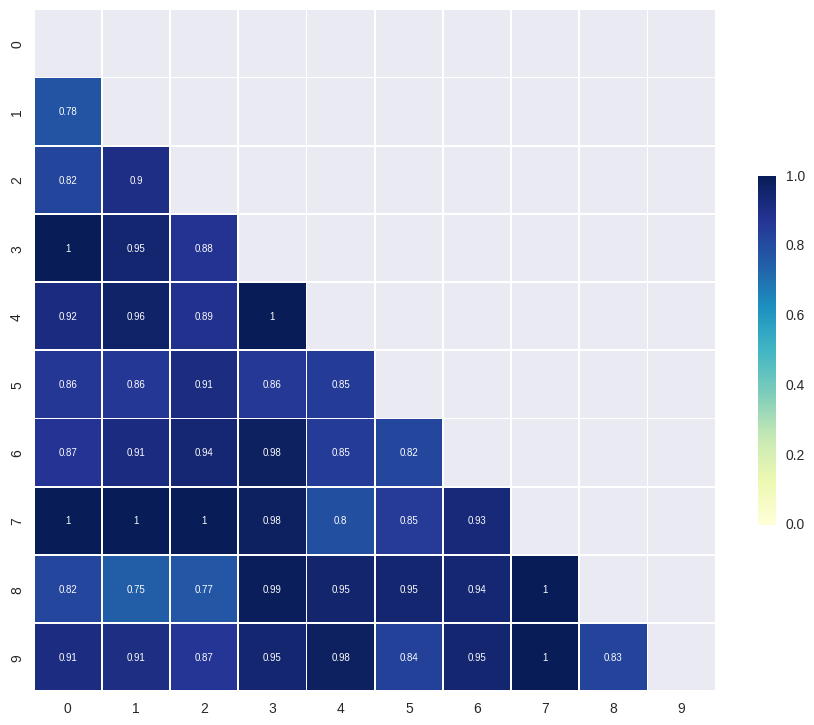

In [256]:

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap="YlGnBu"
#cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(sim_mat, mask=mask, cmap=cmap, vmax=.3, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, annot_kws={"size": 7} )
        

In [277]:
pinot_df_AK = pinot_df.loc[pinot_df['taster_name'] == 'Anna Lee C. Iijima']
pinot_df_AK = pinot_df_AK.loc[pinot_df_AK['province'].isin(pinot_df_AK.province.value_counts()[:10].index)]

In [280]:
pinot_df_AK["group_rank2"] = pinot_df_AK.groupby("province")["points_randn"].rank(ascending=0,method='dense')
pinot_df_AK_topranks = pinot_df_AK.loc[(pinot_df_AK['group_rank2'] == 1)]
pinot_df_AK_topranks = pinot_df_AK_topranks.reset_index()

In [284]:
print(pinot_df_AK.groupby(['province']).size())

province
Mosel          3
Nahe           1
New York       8
Rheingau       1
Rheinhessen    1
dtype: int64


In [282]:
pinot_df_AK_topranks

,index,taster_name,description,points,title,description_token,province,points_randn,group_rank2
0,32388,Anna Lee C. Iijima,Made from Pinot Noir vinified like a white win...,87,Paul Anheuser 2015 Blanc de Noir Pinot Noir (N...,"[[made, pinot, noir, vinified, like, white, wi...",Nahe,86.955725,1.0
1,43472,Anna Lee C. Iijima,"Ripe, powerful red-cherry flavors are balanced...",90,Von Schleinitz 2015 Pinot Noir (Mosel),"[[ripe, powerful, redcherry, flavor, balanced,...",Mosel,89.930732,1.0
2,108777,Anna Lee C. Iijima,Whiffs of hazelnut and raspberry introduce thi...,85,Carl Ehrhard 2015 Rüdesheim Blanc de Noirs Tro...,"[[whiff, hazelnut, raspberry, introduce, dry, ...",Rheingau,85.040680,1.0
3,119532,Anna Lee C. Iijima,A bit of aeration brings out depth to bright c...,92,N. Kendall Wines 2015 Pinot Noir (Finger Lakes),"[[bit, aeration, brings, depth, bright, cherry...",New York,92.008199,1.0
4,121579,Anna Lee C. Iijima,"Fresh, primary red cherry and raspberry flavor...",89,P.J. Valckenberg 2015 Undone Pinot Noir (Rhein...,"[[fresh, primary, red, cherry, raspberry, flav...",Rheinhessen,89.056263,1.0


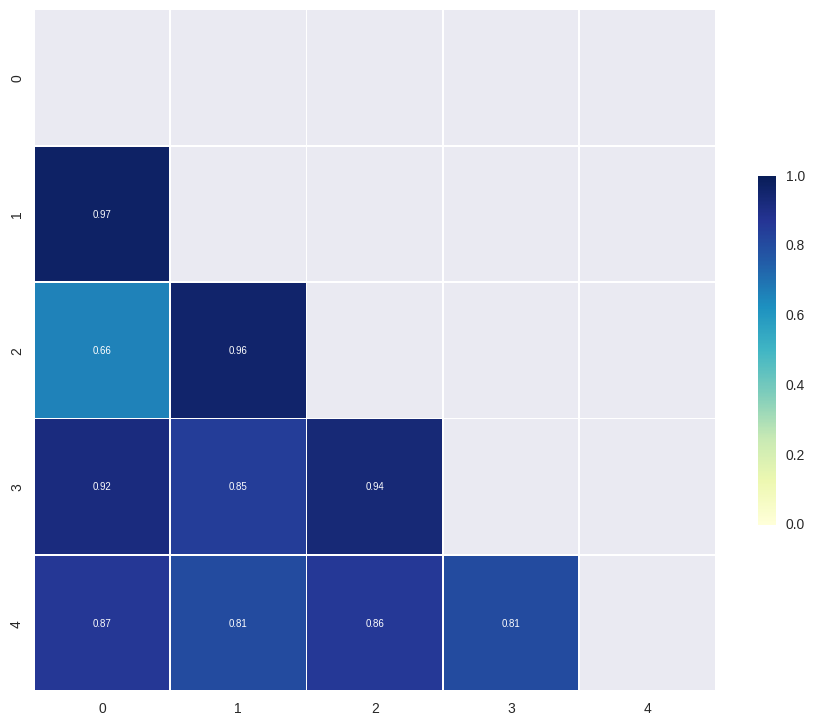

In [283]:
sim_score = []
for doc in pinot_df_AK_topranks['description_token']:
    doc = doc[0]
    #print(doc)
    for other_doc in pinot_df_AK_topranks['description_token']:
        other_doc = other_doc[0]
        sim_score.append(model.wv.wmdistance(doc, other_doc)) 

sim_mat = np.array(sim_score).reshape((5, 5))

mask = np.zeros_like(sim_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap="YlGnBu"
#cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(sim_mat, mask=mask, cmap=cmap, vmax=.3, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, annot_kws={"size": 7} )
        


In [290]:
print('0:\n')
print(pinot_df_AK_topranks.description[0])
print('\n2:\n')
print(pinot_df_AK_topranks.description[2])

print('\n')
print('#################################')
print(' The two reviews talk about a white wine from Pinot Noir. Dryness. Meant to be consumed now.')

0:

Made from Pinot Noir vinified like a white wine, this fruity, fresh wine is a shade off dry. On the palate, hints of cherry and blossom, accent zesty grapefruit and lemon flavors. The finish is refreshingly dry. Drink now.

2:

Whiffs of hazelnut and raspberry introduce this dry Blanc de Noir, a white wine made from Pinot Noir grapes. Red berry flavors on the palate run a touch ruddy, but vibrant acidity brightens the finish. Drink now.


#################################
 The two reviews talk about a white wine from Pinot Noir. Dryness. Meant to be consumed now.


    * We see that the distances have slighly reduced now that we have narrowed down to a single reviewer. Next we will apply another filter to keep the same variety (Pinot Noir) from a single province only and see  the effect on the distances.

In [291]:
pinot_df_MS = pinot_df.loc[pinot_df['province'] == 'Casablanca Valley']

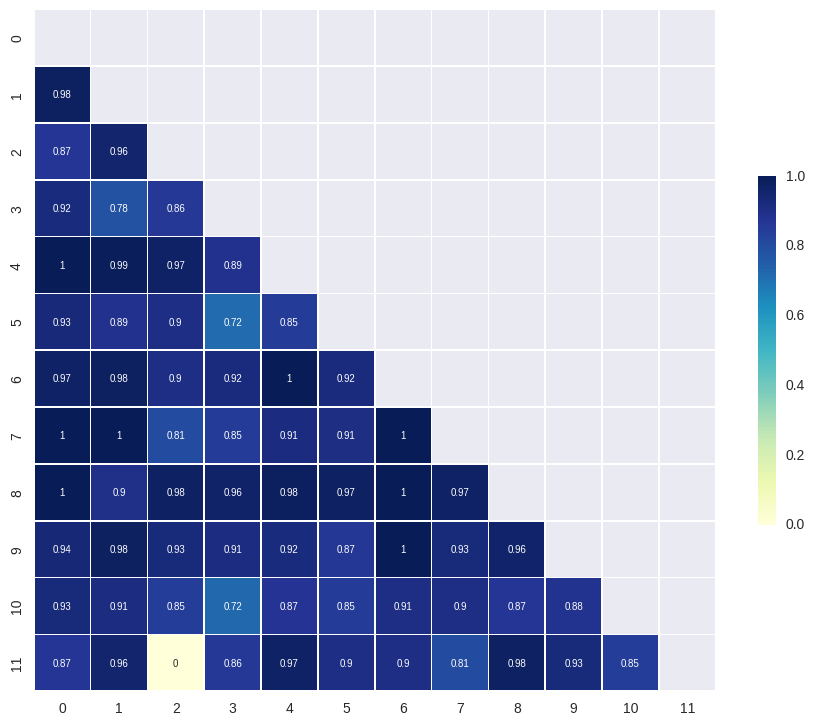

In [294]:
sim_score = []
for doc in pinot_df_MS['description_token']:
    doc = doc[0]
    #print(doc)
    for other_doc in pinot_df_MS['description_token']:
        other_doc = other_doc[0]
        sim_score.append(model.wv.wmdistance(doc, other_doc)) 

sim_mat = np.array(sim_score).reshape((12, 12))

mask = np.zeros_like(sim_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap="YlGnBu"
#cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(sim_mat, mask=mask, cmap=cmap, vmax=.3, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, annot_kws={"size": 7} )
        


### Phrase Modeling


#### Why do phrase modeling ? 

#### Well simple answer is plain BOW after tokenization just sucks..in the human spoken language a lot of times certain words come in sequences. For Eg New York, Thin crust pizza, full bodied wine, petit verdot etc.. To extract meaningful information out of text it is helpful to combine the tokens that usually coexist. So we can combine unigrams (single words) to bigrams (petit + verdot => petit verdot) and turn bigrams to trigrams (thin crust + pizza => thin crust pizza)



#### Also in this section, I will be using a really awesome library called spaCY (https://spacy.io/). You gotta try it out. Its production level NLP framework that has a C backend which makes it blazingly FAST. I will use spaCY for the text pre-processing, showing some inbuilt features such as POS tagging aka Part of Speech , just in case someone was thinking otherwise :) and performing Phrase Modeling 

In [8]:
nlp = spacy.load('en')

/anaconda/envs/py35/lib/python3.5/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/anaconda/envs/py35/lib/python3.5/site-packages/msgpack_numpy.py:88: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr))[0]
/anaconda/envs/py35/lib/python3.5/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/anaconda/envs/py35/lib/python3.5/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/anaconda/envs/p

In [9]:
intermediate_directory = os.path.join(os.path.join('', 'data'),'intermediate')
review_txt_filepath = os.path.join(intermediate_directory,
                                   'review_text_all.txt')

In [60]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 1 == 1:
    
    review_count = 0

    # create & open a new file in write mode
    with codecs.open(review_txt_filepath, 'w', encoding='utf_8') as review_txt_file:


        # loop through all reviews in the existing file and convert to dict
        for review in df.description:
            # write the wine review as a line in the new file
            # escape newline characters in the original review text
            review_txt_file.write(review.replace('\n', '\\n') + '\n')
            review_count += 1
    
else:
    
    with codecs.open(review_txt_filepath, encoding='utf_8') as review_txt_file:
        for review_count, line in enumerate(review_txt_file):
            pass
        
    #print u'Text from {:,} restaurant reviews in the txt file.'.format(review_count + 1)

CPU times: user 704 ms, sys: 51.4 ms, total: 755 ms
Wall time: 754 ms


In [62]:
with codecs.open(review_txt_filepath, encoding='utf_8') as f:
    sample_review = list(it.islice(f, 8, 9))[0]
    sample_review = sample_review.replace('\\n', '\n')
        
print(sample_review)

Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. It's fruity and fresh, with an elegant, sprightly footprint.



In [67]:
for num, sentence in enumerate(parsed_review.sents):
    print('Sentence {}:'.format(num + 1))
    print(sentence)
    print('')

Sentence 1:
Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine.

Sentence 2:
It's fruity and fresh, with an elegant, sprightly footprint.




In [68]:
for num, entity in enumerate(parsed_review.ents):
    print('Entity {}:'.format(num + 1), entity, '-', entity.label_)
    print('')

Entity 1: 
 - GPE



In [63]:
%%time
parsed_review = nlp(sample_review)

CPU times: user 47.6 ms, sys: 120 ms, total: 167 ms
Wall time: 33.9 ms


In [77]:
token_text = [token.orth_ for token in parsed_review]
token_pos = [token.pos_ for token in parsed_review]

pd.DataFrame({'token_text': token_text,
     'token_pos': token_pos
    })

,token_pos,token_text
0,NOUN,Savory
1,VERB,dried
2,NOUN,thyme
3,VERB,notes
4,ADJ,accent
5,NOUN,sunnier
6,NOUN,flavors
7,ADP,of
8,VERB,preserved
9,NOUN,peach


In [78]:
token_lemma = [token.lemma_ for token in parsed_review]
token_shape = [token.shape_ for token in parsed_review]

pd.DataFrame({'token_text': token_text,
     'token_lemma': token_lemma,
     'token_shape' : token_shape
    })

,token_lemma,token_shape,token_text
0,savory,Xxxxx,Savory
1,dry,xxxx,dried
2,thyme,xxxx,thyme
3,note,xxxx,notes
4,accent,xxxx,accent
5,sunnier,xxxx,sunnier
6,flavor,xxxx,flavors
7,of,xx,of
8,preserve,xxxx,preserved
9,peach,xxxx,peach


In [10]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

def line_review(filename):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')
            
def lemmatized_sentence_corpus(filename):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, and yield sentences
    """
    
    for parsed_review in nlp.pipe(line_review(filename),
                                  batch_size=10000, n_threads=4):
        
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent
                             if not punct_space(token)])

In [80]:
unigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'unigram_sentences_all.txt')

In [81]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 1:

    with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(review_txt_filepath):
            f.write(sentence + '\n')

CPU times: user 1h 2min 13s, sys: 2h 3min 52s, total: 3h 6min 5s
Wall time: 28min 7s


In [82]:
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [84]:
for unigram_sentence in it.islice(unigram_sentences, 210, 240):
    print(u' '.join(unigram_sentence))
    print(u'')

this wine have a touch of perceptible sweetness on -PRON- tropical nose yet taste dry show a straightforward approach to this crisp coastal grow variety

apricot melon and guava wrap around a lightness of body and texture

all red bordeaux variety be represent in this blend except for petit verdot

together -PRON- offer a simple tannic structure that strengthen a chewiness of leather tobacco and a touch of cedar

full bodied -PRON- be a ripe bold and brawny wine

freshness characterize the nose green pear ivy leaf and citrus note play on nose and palate

this be light footed easy drinking and charming

drink soon while flavor be fresh

barrel note be prominent with aroma of creamsicle and baking spice

the palate be broad and dry with stone fruit and barrel flavor

-PRON- provide intrigue but the wood seem to get in the way at time

this be a dense wine pack with both tannin and acidity

-PRON- bring out the ageworthiness of this appellation with -PRON- rich potential and dark mineral 

#### Ok, this looks like plain text with all the tokens still separate as we are still at Unigram level (single word). Next we build a bi-gram model

In [85]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')

In [86]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute modeling yourself.
if 0 == 1:

    bigram_model = Phrases(unigram_sentences)

    bigram_model.save(bigram_model_filepath)
    
# load the finished model from disk
bigram_model = Phrases.load(bigram_model_filepath)

/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/ana

CPU times: user 31.8 s, sys: 247 ms, total: 32 s
Wall time: 32 s


In [87]:
bigram_sentences_filepath = os.path.join(intermediate_directory,
                                         'bigram_sentences_all.txt')

In [88]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 1:

    with codecs.open(bigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
        for unigram_sentence in unigram_sentences:
            
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            
            f.write(bigram_sentence + '\n')

/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 1min 23s, sys: 186 ms, total: 1min 23s
Wall time: 1min 23s


In [89]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [90]:
for bigram_sentence in it.islice(bigram_sentences, 210, 240):
    print(u' '.join(bigram_sentence))
    print(u'')

this wine have a touch of perceptible_sweetness on -PRON- tropical nose yet taste dry show a straightforward approach to this crisp coastal grow variety

apricot melon and guava wrap_around a lightness of body and texture

all red bordeaux_variety be represent in this blend except_for petit_verdot

together -PRON- offer a simple tannic structure that strengthen a chewiness of leather tobacco and a touch of cedar

full_bodied -PRON- be a ripe bold and brawny wine

freshness characterize the nose green pear ivy_leaf and citrus note play on nose and palate

this be light_footed easy_drinking and charming

drink soon while flavor be fresh

barrel note be prominent with aroma of creamsicle and baking_spice

the palate be broad and dry with stone fruit and barrel flavor

-PRON- provide_intrigue but the wood seem to get in the way at time

this be a dense wine pack with both tannin and acidity

-PRON- bring_out the ageworthiness of this appellation with -PRON- rich potential and dark mineral 

#### You will see that the bigram model has picked up some of the jointy occuring word sequences such as pinot_gris, pencil_lead, petit_verdot, baking_spice, except_for, full_bodied, ivy_leaf etc. 

#### Let's take it one step further and turn it to a trigram model

In [91]:
trigram_model_filepath = os.path.join(intermediate_directory,
                                      'trigram_model_all')

In [95]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute modeling yourself.
if 0 == 1:

    trigram_model = Phrases(bigram_sentences)

    trigram_model.save(trigram_model_filepath)
    
# load the finished model from disk
trigram_model = Phrases.load(trigram_model_filepath)

/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/ana

CPU times: user 29.8 s, sys: 152 ms, total: 30 s
Wall time: 30 s


In [99]:
trigram_sentences_filepath = os.path.join(intermediate_directory,
                                          'trigram_sentences_all.txt')

In [100]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 1:

    with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
        
        for bigram_sentence in bigram_sentences:
            
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            
            f.write(trigram_sentence + '\n')

/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 1min 21s, sys: 81.8 ms, total: 1min 21s
Wall time: 1min 21s


In [101]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [103]:
for trigram_sentence in it.islice(trigram_sentences, 210, 240):
    print(u' '.join(trigram_sentence))
    print(u'')

this wine have a touch of perceptible_sweetness on -PRON- tropical nose yet taste dry show a straightforward approach to this crisp coastal grow variety

apricot melon and guava wrap_around a lightness of body and texture

all red bordeaux_variety be represent in this blend except_for petit_verdot

together -PRON- offer a simple tannic structure that strengthen a chewiness of leather tobacco and a touch of cedar

full_bodied -PRON- be a ripe bold and brawny wine

freshness characterize the nose green pear ivy_leaf and citrus note play on nose and palate

this be light_footed easy_drinking and charming

drink_soon while flavor be fresh

barrel note be prominent with aroma of creamsicle and baking_spice

the palate be broad and dry with stone fruit and barrel flavor

-PRON- provide_intrigue but the wood seem to get in the way at time

this be a dense wine pack with both tannin and acidity

-PRON- bring_out the ageworthiness of this appellation with -PRON- rich potential and dark mineral 

     
#### Looks like the second-order phrase model was successful. We're now seeing three-word phrases, such as "drink_sooner_rather" and "freshly_press_apple".

#### The final step of our text preparation process circles back to the complete text of the reviews. We're going to run the complete text of the reviews through a pipeline that applies our text normalization and phrase models.

#### In addition, we'll remove stopwords at this point. Stopwords are very common words, like a, the, and, and so on, that serve functional roles in natural language, but typically don't contribute to the overall meaning of text. Filtering stopwords is a common procedure that allows higher-level NLP modeling techniques to focus on the words that carry more semantic weight.

#### Finally, we'll write the transformed text out to a new file, with one review per line.

In [104]:
trigram_reviews_filepath = os.path.join(intermediate_directory,
                                        'trigram_transformed_reviews_all.txt')

In [108]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to execute data prep yourself.
if 0 == 1:

    with codecs.open(trigram_reviews_filepath, 'w', encoding='utf_8') as f:
        
        for parsed_review in nlp.pipe(line_review(review_txt_filepath),
                                      batch_size=10000, n_threads=4):
            
            # lemmatize the text, removing punctuation and whitespace
            unigram_review = [token.lemma_ for token in parsed_review
                              if not punct_space(token)]
            
            # apply the first-order and second-order phrase models
            bigram_review = bigram_model[unigram_review]
            trigram_review = trigram_model[bigram_review]
            
            # remove any remaining stopwords
            trigram_review = [term for term in trigram_review
                              if term not in STOP_WORDS]
            
            # write the transformed review as a line in the new file
            trigram_review = u' '.join(trigram_review)
            f.write(trigram_review + '\n')

/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 1h 3min 32s, sys: 2h 1min 22s, total: 3h 4min 54s
Wall time: 30min 31s


In [110]:
print( u'Original:' + u'\n')

for review in it.islice(line_review(review_txt_filepath), 11, 12):
    print(review)

print(u'----' + u'\n')
print(u'Transformed:' + u'\n')

with codecs.open(trigram_reviews_filepath, encoding='utf_8') as f:
    for review in it.islice(f, 11, 12):
        print(review)

Original:

This is a dry wine, very spicy, with a tight, taut texture and strongly mineral character layered with citrus as well as pepper. It's a food wine with its almost crisp aftertaste.

----

Transformed:

dry wine spicy tight taut texture strongly mineral character layer citrus as_well pepper -PRON- food wine -PRON- crisp aftertaste



### Topic Models


Topic modeling is family of techniques that can be used to describe and summarize the documents in a corpus according to a set of latent "topics". For this demo, we'll be using Latent Dirichlet Allocation or LDA, a popular approach to topic modeling.

In many conventional NLP applications, documents are represented a mixture of the individual tokens (words and phrases) they contain. In other words, a document is represented as a vector of token counts. There are two layers in this model — documents and tokens — and the size or dimensionality of the document vectors is the number of tokens in the corpus vocabulary. This approach has a number of disadvantages:

Document vectors tend to be large (one dimension for each token ⇒ lots of dimensions)
They also tend to be very sparse. Any given document only contains a small fraction of all tokens in the vocabulary, so most values in the document's token vector are 0.
The dimensions are fully indepedent from each other — there's no sense of connection between related tokens, such as knife and fork.
LDA injects a third layer into this conceptual model. Documents are represented as a mixture of a pre-defined number of topics, and the topics are represented as a mixture of the individual tokens in the vocabulary. The number of topics is a model hyperparameter selected by the practitioner. LDA makes a prior assumption that the (document, topic) and (topic, token) mixtures follow Dirichlet probability distributions. This assumption encourages documents to consist mostly of a handful of topics, and topics to consist mostly of a modest set of the tokens.

In [3]:
intermediate_directory = os.path.join(os.path.join('', 'data'),'intermediate')
trigram_dictionary_filepath = os.path.join(intermediate_directory,'trigram_dict_all.dict')

In [4]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to learn the dictionary yourself.
if 0 == 1:

    trigram_reviews = LineSentence(trigram_reviews_filepath)

    # learn the dictionary by iterating over all of the reviews
    trigram_dictionary = Dictionary(trigram_reviews)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=10, no_above=0.4)
    trigram_dictionary.compactify()

    trigram_dictionary.save(trigram_dictionary_filepath)
    
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

CPU times: user 9.5 ms, sys: 3.35 ms, total: 12.8 ms
Wall time: 11.9 ms


  
 
Like many NLP techniques, LDA uses a simplifying assumption known as the bag-of-words model. In the bag-of-words model, a document is represented by the counts of distinct terms that occur within it. Additional information, such as word order, is discarded.

Using the gensim Dictionary we learned to generate a bag-of-words representation for each review. The trigram_bow_generator function implements this. We'll save the resulting bag-of-words reviews as a matrix.

In the following code, "bag-of-words" is abbreviated as bow.

In [5]:
trigram_bow_filepath = os.path.join(intermediate_directory,
                                    'trigram_bow_corpus_all.mm')

In [6]:
def trigram_bow_generator(filepath):
    """
    generator function to read reviews from a file
    and yield a bag-of-words representation
    """
    
    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

In [7]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to build the bag-of-words corpus yourself.
if 0 == 1:

# generate bag-of-words representations for
# all reviews and save them as a matrix
    MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_reviews_filepath))
    
# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

CPU times: user 25 ms, sys: 7.34 ms, total: 32.4 ms
Wall time: 30.8 ms


 

With the bag-of-words corpus, we're finally ready to learn our topic model from the reviews. We simply need to pass the bag-of-words matrix and Dictionary from our previous steps to LdaMulticore as inputs, along with the number of topics the model should learn. For this demo, we're asking for 10 topics.

In [8]:
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')

In [9]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to train the LDA model yourself.
if 0 == 1:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=10,
                           id2word=trigram_dictionary,
                           workers=7)
    
    lda.save(lda_model_filepath)
    
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

CPU times: user 34.3 ms, sys: 9.5 ms, total: 43.8 ms
Wall time: 43.1 ms



 
#### Our topic model is now trained and ready to use! Since each topic is represented as a mixture of tokens, you can manually inspect which tokens have been grouped together into which topics to try to understand the patterns the model has discovered in the data.

In [10]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=topn):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [11]:
explore_topic(topic_number=0, topn = 20)

term                 frequency

cherry               0.026
palate               0.026
tannin               0.024
black                0.021
aroma                0.020
red                  0.017
finish               0.014
note                 0.013
offer                0.012
dry                  0.010
ripe                 0.010
berry                0.010
hint                 0.010
plum                 0.009
acidity              0.008
nose                 0.008
firm                 0.008
alongside            0.007
clove                0.007
licorice             0.006


 
  
 
It's possible to go through and inspect each topic in the same way, and try to assign a human-interpretable label that captures the essence of each one. I've given it a shot for all 50 topics below.

In [12]:
topic_names = {0: u'cherries, tannins',
               1: u'ripe, rich, age, character',
               2: u'acidic red wine',
               3: u'cherries ,black plums, tannins',
               4: u'palate_finish_fresh_citrus',
               5: u'white wines acidic palate',
               6: u'ripe berry cherry',
               7: u'aroma_notes_palate',
               8: u'black_cherries fruits',
               9: u'dry_acidic'
               }

In [13]:
topic_names_filepath = os.path.join(intermediate_directory, 'topic_names.pkl')

with open(topic_names_filepath, 'wb') as f:
    pickle.dump(topic_names, f)

#### I wanted to end this section with a visualization of topics generated by LDA. However due to some environment issues related to Math Kernel Libraries and Numpy, i will leave that for the next post :)


#### Hopefully you enjoyed reading ! Feel free to drop comments, follow up ideas :). With that, let me open that bottle of 2015 Meomi Pinot Noir that has been staring at me for last 2 weeks.